Reloading Tuner from tuner_results\tcn_energy_forecasting\tuner0.json
Epoch 1/50
4/4 - 3s - loss: 0.5017 - mae: 0.5710 - val_loss: 0.0911 - val_mae: 0.2395 - 3s/epoch - 653ms/step
Epoch 2/50
4/4 - 0s - loss: 0.1064 - mae: 0.2606 - val_loss: 0.1030 - val_mae: 0.2529 - 194ms/epoch - 49ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0583 - mae: 0.1882 - val_loss: 0.0821 - val_mae: 0.2235 - 166ms/epoch - 42ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0478 - mae: 0.1769 - val_loss: 0.0616 - val_mae: 0.2077 - 152ms/epoch - 38ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0398 - mae: 0.1608 - val_loss: 0.0386 - val_mae: 0.1573 - 156ms/epoch - 39ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0339 - mae: 0.1417 - val_loss: 0.0363 - val_mae: 0.1509 - 166ms/epoch - 41ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0289 - mae: 0.1308 - val_loss: 0.0363 - val_mae: 0.1532 - 166ms/epoch - 42ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0264 - mae: 0.1280 - val_loss: 0.0338 - val_mae: 0.1482 - 165ms/epoch - 41ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0241 -

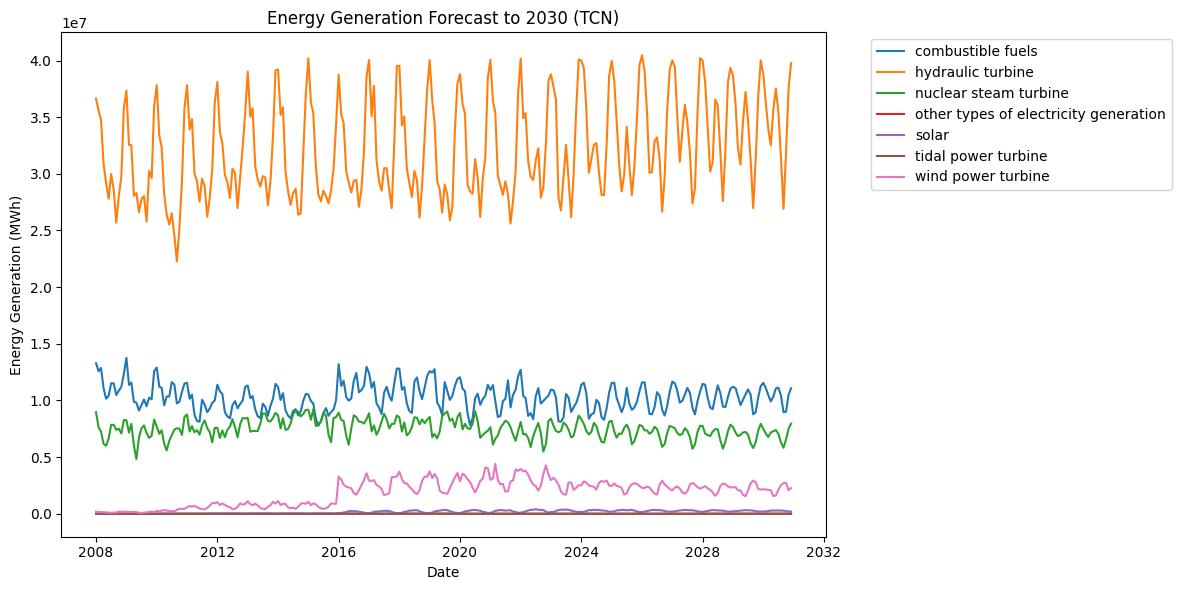

In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tcn import TCN
from kerastuner.tuners import RandomSearch

# ------------------ Utility Functions ------------------ #
# Load and preprocess the dataset
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data['date'] = pd.to_datetime(data['date'])
    df_grouped = data.groupby(['date', 'generation_type'], as_index=False)['megawatt_hours'].sum()
    return df_grouped

# Ensure all generation types are represented for every date
def standardize_generation_types(df, unique_types):
    all_dates = df['date'].unique()
    standardized_rows = [
        {'date': date, 'generation_type': g_type, 'megawatt_hours': 0}
        for date in all_dates
        for g_type in unique_types
        if g_type not in df[df['date'] == date]['generation_type'].values
    ]
    return pd.concat([df, pd.DataFrame(standardized_rows)], ignore_index=True)

# Scale the data
def scale_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

# Create input-output sequences for time-series data
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Forecast future energy generation
def forecast_future(model, data_scaled, scaler, n_steps, forecast_horizon, columns):
    forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, data_scaled.shape[1])
    forecast = []
    for _ in range(len(forecast_horizon)):
        prediction = model.predict(forecast_input)
        forecast.append(prediction[0])
        forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)
    forecast_rescaled = scaler.inverse_transform(forecast)
    return pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=columns)

# Plot forecasted values
def plot_forecasts(df_pivot, forecast_df, title):
    combined = pd.concat([df_pivot, forecast_df])
    plt.figure(figsize=(12, 6))
    for column in df_pivot.columns:
        plt.plot(combined.index, combined[column], label=column)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Energy Generation (MWh)")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# ------------------ Model Functions ------------------ #
# Build the TCN model for Keras Tuner
def build_tcn_model(hp):
    dilation_depth = hp.Int('dilation_depth', min_value=2, max_value=6, step=2)
    dilations = [2**i for i in range(dilation_depth)]
    
    model = Sequential([
        Input(shape=(n_steps, X_train.shape[2])),
        TCN(
            nb_filters=hp.Int('nb_filters', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('kernel_size', values=[2, 3, 5]),
            nb_stacks=hp.Int('nb_stacks', min_value=1, max_value=2),
            dilations=dilations,
            padding='causal',
            use_skip_connections=hp.Boolean('use_skip_connections'),
            dropout_rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1),
            return_sequences=False,
            activation=hp.Choice('activation', values=['relu', 'tanh']),
        ),
        Dense(X_train.shape[2])
    ])
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mse',
        metrics=['mae']
    )
    return model


# ------------------ Main Script ------------------ #
if __name__ == "__main__":
    filepath = r'data\processed\canada_energy.csv'

    # Load and process data
    df_grouped = load_and_preprocess_data(filepath)
    unique_generation_types = df_grouped['generation_type'].unique()
    df_standardized = standardize_generation_types(df_grouped, unique_generation_types)
    df_pivot = df_standardized.pivot(index='date', columns='generation_type', values='megawatt_hours').fillna(0)
    df_pivot[df_pivot < 0] = 0

    # Scale data
    data_scaled, scaler = scale_data(df_pivot)

    # Define time steps
    n_steps = 36
    X, y = create_sequences(data_scaled, n_steps)
    test_size = 24
    train_data, test_data = data_scaled[:-test_size], data_scaled[-test_size - n_steps:]
    X_train, y_train = create_sequences(train_data, n_steps)
    X_test, y_test = create_sequences(test_data, n_steps)

    # Hyperparameter tuning with Keras Tuner
    tuner = RandomSearch(
        build_tcn_model,
        objective='val_loss',
        max_trials=20,
        executions_per_trial=2,
        directory='tuner_results',
        project_name='tcn_energy_forecasting'
    )
    tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, verbose=2)

    # Get best hyperparameters and train model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

    # Forecast future values
    forecast_horizon = pd.date_range(df_pivot.index[-1] + pd.DateOffset(months=1), '2030-12-01', freq='MS')
    forecast_df_tcn = forecast_future(best_model, data_scaled, scaler, n_steps, forecast_horizon, df_pivot.columns)

    # Plot results
    plot_forecasts(df_pivot, forecast_df_tcn, "Energy Generation Forecast to 2030 (TCN)")

    


In [9]:
#print the best hyperparameters
print(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)




{'dilation_depth': 6, 'nb_filters': 80, 'kernel_size': 3, 'nb_stacks': 1, 'use_skip_connections': False, 'dropout_rate': 0.0, 'activation': 'tanh', 'optimizer': 'adam'}


In [3]:
    #plot the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#label the axes
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Epoch')
#show the legend
plt.legend()
plt.show()

    #plot other metrics
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
#label the axes
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Epoch')
#show the legend
plt.legend()
plt.show()    

#print the values of the error metrics
print(history.history['mae'])
print(history.history['val_mae'])
print(history.history['loss'])



    

NameError: name 'history' is not defined

In [2]:
#plot the loss vs epoch
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#label the axes
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Epoch')
#show the legend
plt.legend()
plt.show()


NameError: name 'history' is not defined

Processing Alberta...
Epoch 1/100
5/5 - 2s - loss: 0.5167 - mae: 0.5663 - 2s/epoch - 493ms/step
Epoch 2/100
5/5 - 0s - loss: 0.1221 - mae: 0.2782 - 200ms/epoch - 40ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0584 - mae: 0.1971 - 216ms/epoch - 43ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0369 - mae: 0.1490 - 227ms/epoch - 45ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0319 - mae: 0.1367 - 294ms/epoch - 59ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0236 - mae: 0.1207 - 282ms/epoch - 56ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0225 - mae: 0.1120 - 291ms/epoch - 58ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0187 - mae: 0.1036 - 320ms/epoch - 64ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0158 - mae: 0.0917 - 306ms/epoch - 61ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0145 - mae: 0.0909 - 267ms/epoch - 53ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0135 - mae: 0.0857 - 253ms/epoch - 51ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0127 - mae: 0.0854 - 245ms/epoch - 49ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0113 - mae: 0.0807 - 245ms/epoch 

C:\Users\matth\AppData\Local\Temp\ipykernel_34416\1094011428.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_forecasts = pd.concat([combined_forecasts, forecast_2029_2030], ignore_index=True)


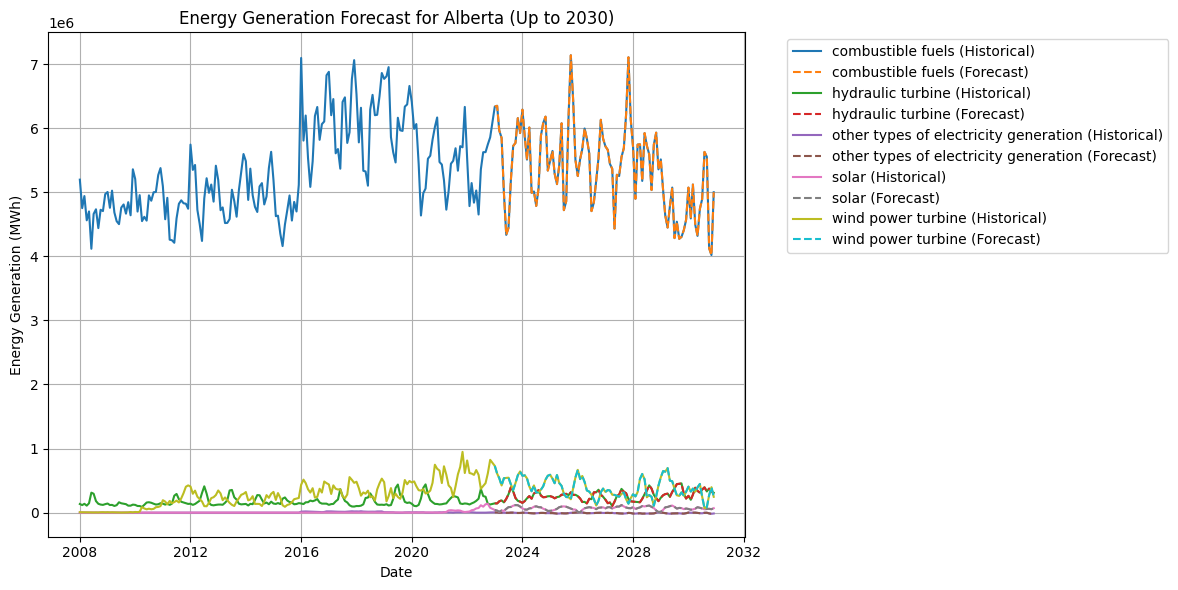

Processing British Columbia...
Epoch 1/100
5/5 - 3s - loss: 0.5776 - mae: 0.6134 - 3s/epoch - 538ms/step
Epoch 2/100
5/5 - 0s - loss: 0.1385 - mae: 0.2863 - 214ms/epoch - 43ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0564 - mae: 0.1921 - 221ms/epoch - 44ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0333 - mae: 0.1440 - 234ms/epoch - 47ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0222 - mae: 0.1124 - 245ms/epoch - 49ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0187 - mae: 0.1086 - 245ms/epoch - 49ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0150 - mae: 0.0910 - 250ms/epoch - 50ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0141 - mae: 0.0871 - 254ms/epoch - 51ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0119 - mae: 0.0762 - 260ms/epoch - 52ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0120 - mae: 0.0782 - 254ms/epoch - 51ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0106 - mae: 0.0731 - 263ms/epoch - 53ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0104 - mae: 0.0718 - 259ms/epoch - 52ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0099 - mae: 0.0709 - 261

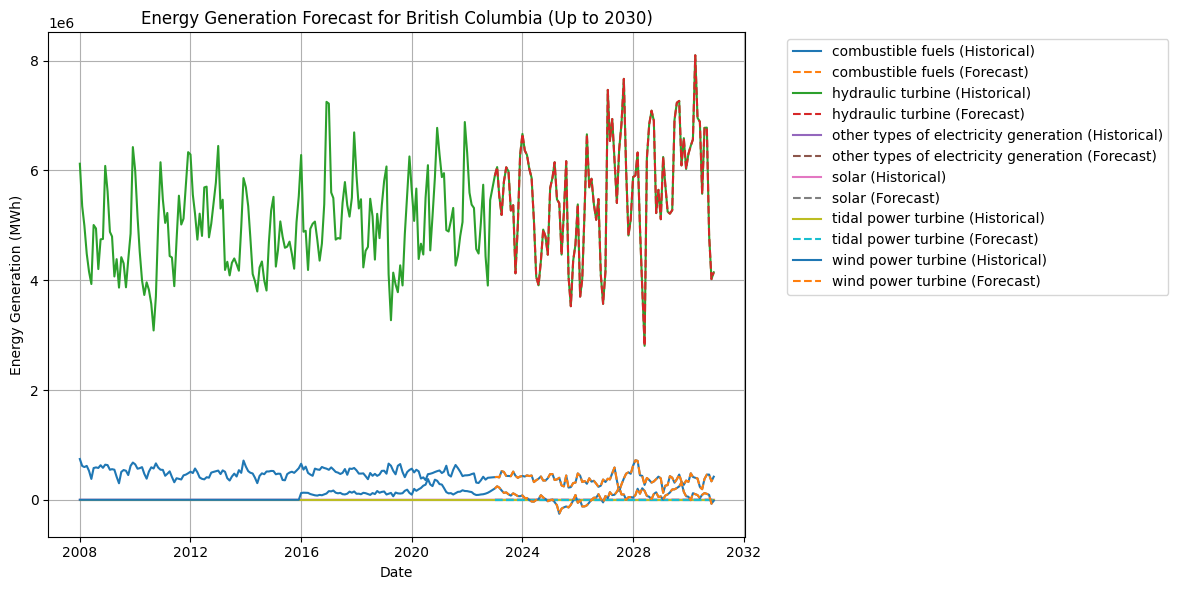

Processing Manitoba...
Epoch 1/100
5/5 - 3s - loss: 0.4630 - mae: 0.4751 - 3s/epoch - 539ms/step
Epoch 2/100
5/5 - 0s - loss: 0.0928 - mae: 0.2446 - 214ms/epoch - 43ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0496 - mae: 0.1793 - 228ms/epoch - 46ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0398 - mae: 0.1459 - 242ms/epoch - 48ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0215 - mae: 0.1056 - 258ms/epoch - 52ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0217 - mae: 0.1117 - 256ms/epoch - 51ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0175 - mae: 0.0945 - 258ms/epoch - 52ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0160 - mae: 0.0883 - 254ms/epoch - 51ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0142 - mae: 0.0788 - 260ms/epoch - 52ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0132 - mae: 0.0802 - 258ms/epoch - 52ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0126 - mae: 0.0756 - 256ms/epoch - 51ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0117 - mae: 0.0732 - 254ms/epoch - 51ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0115 - mae: 0.0735 - 259ms/epoch

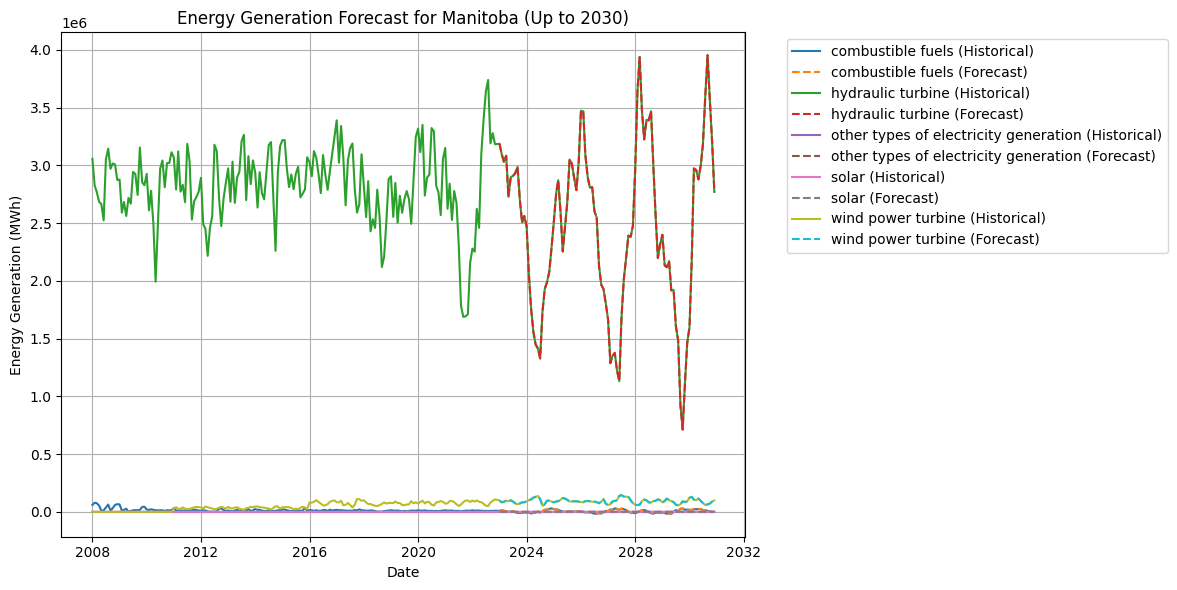

Processing New Brunswick...
Epoch 1/100
5/5 - 3s - loss: 0.5270 - mae: 0.4950 - 3s/epoch - 597ms/step
Epoch 2/100
5/5 - 0s - loss: 0.1153 - mae: 0.2727 - 320ms/epoch - 64ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0622 - mae: 0.2017 - 378ms/epoch - 76ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0422 - mae: 0.1555 - 403ms/epoch - 81ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0339 - mae: 0.1443 - 406ms/epoch - 81ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0320 - mae: 0.1362 - 415ms/epoch - 83ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0219 - mae: 0.1047 - 412ms/epoch - 82ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0217 - mae: 0.1048 - 376ms/epoch - 75ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0195 - mae: 0.1026 - 320ms/epoch - 64ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0181 - mae: 0.0936 - 313ms/epoch - 63ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0165 - mae: 0.0924 - 306ms/epoch - 61ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0163 - mae: 0.0883 - 302ms/epoch - 60ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0144 - mae: 0.0838 - 300ms/

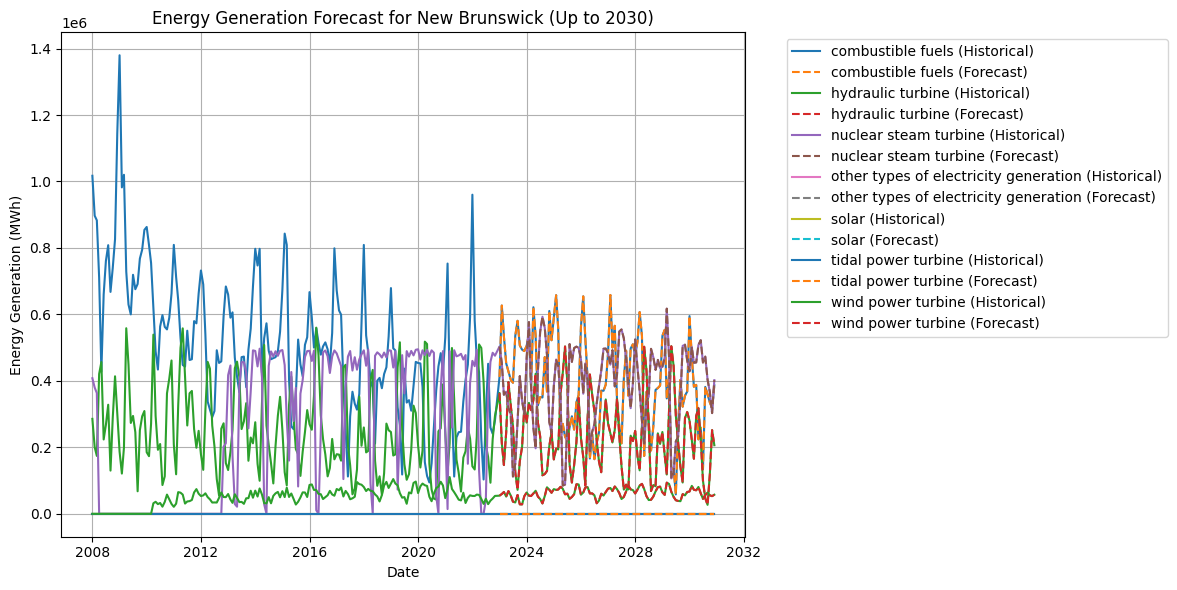

Processing Newfoundland And Labrador...
Epoch 1/100
5/5 - 3s - loss: 0.2966 - mae: 0.4128 - 3s/epoch - 532ms/step
Epoch 2/100
5/5 - 0s - loss: 0.0569 - mae: 0.1859 - 232ms/epoch - 46ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0346 - mae: 0.1488 - 251ms/epoch - 50ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0196 - mae: 0.1101 - 275ms/epoch - 55ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0135 - mae: 0.0893 - 305ms/epoch - 61ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0118 - mae: 0.0819 - 281ms/epoch - 56ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0097 - mae: 0.0740 - 285ms/epoch - 57ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0081 - mae: 0.0675 - 286ms/epoch - 57ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0079 - mae: 0.0662 - 283ms/epoch - 57ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0071 - mae: 0.0616 - 297ms/epoch - 59ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0066 - mae: 0.0590 - 295ms/epoch - 59ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0061 - mae: 0.0550 - 305ms/epoch - 61ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0058 - mae: 0.0

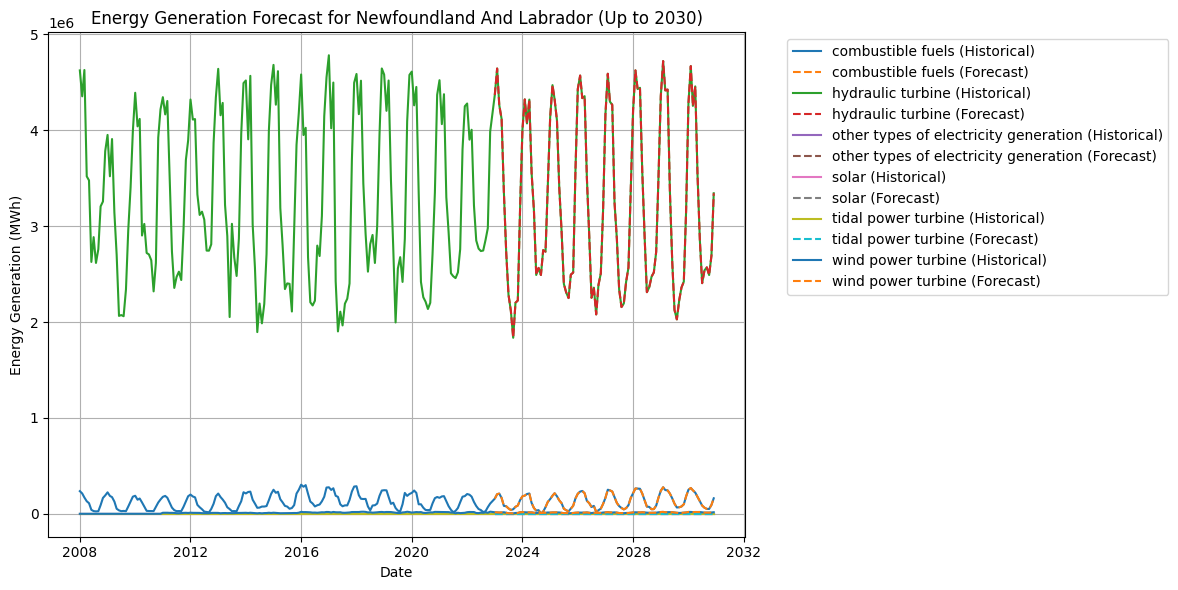

Processing Northwest Territories...
Epoch 1/100
5/5 - 2s - loss: 0.5683 - mae: 0.5499 - 2s/epoch - 453ms/step
Epoch 2/100
5/5 - 0s - loss: 0.0798 - mae: 0.2189 - 254ms/epoch - 51ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0496 - mae: 0.1829 - 288ms/epoch - 58ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0401 - mae: 0.1610 - 316ms/epoch - 63ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0261 - mae: 0.1263 - 295ms/epoch - 59ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0227 - mae: 0.1165 - 283ms/epoch - 57ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0212 - mae: 0.1098 - 277ms/epoch - 55ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0178 - mae: 0.1013 - 274ms/epoch - 55ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0173 - mae: 0.1009 - 274ms/epoch - 55ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0159 - mae: 0.0927 - 278ms/epoch - 56ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0145 - mae: 0.0894 - 275ms/epoch - 55ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0141 - mae: 0.0900 - 270ms/epoch - 54ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0138 - mae: 0.0837 

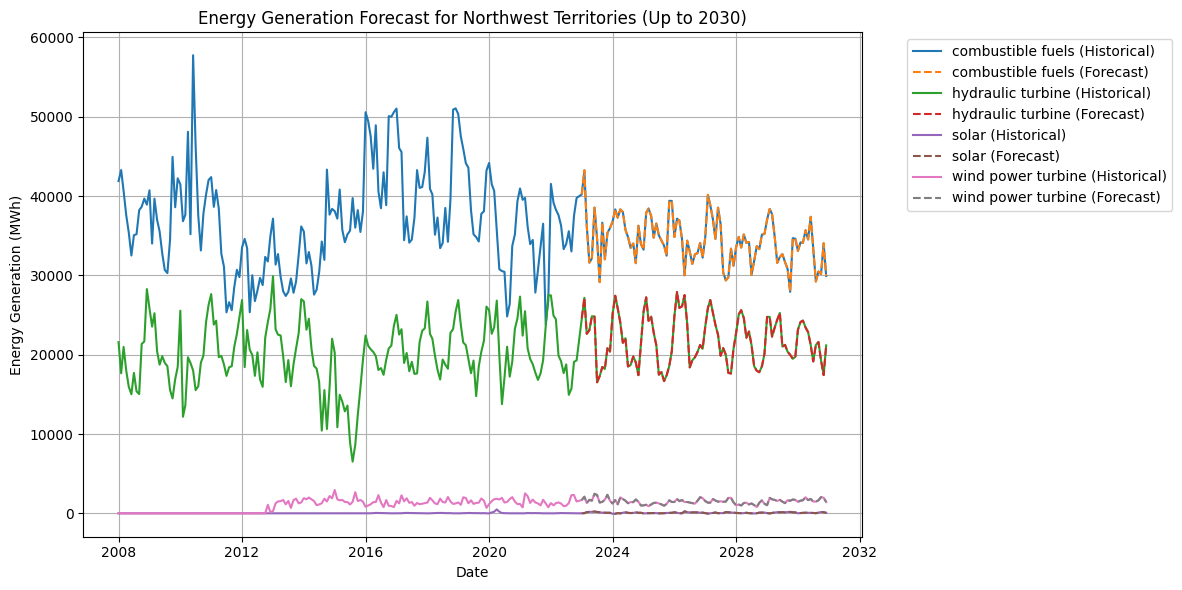

Processing Nova Scotia...
Epoch 1/100
5/5 - 3s - loss: 0.4022 - mae: 0.5022 - 3s/epoch - 592ms/step
Epoch 2/100
5/5 - 0s - loss: 0.0966 - mae: 0.2497 - 279ms/epoch - 56ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0460 - mae: 0.1717 - 265ms/epoch - 53ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0296 - mae: 0.1342 - 279ms/epoch - 56ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0262 - mae: 0.1270 - 317ms/epoch - 63ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0196 - mae: 0.1041 - 328ms/epoch - 66ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0184 - mae: 0.1001 - 285ms/epoch - 57ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0167 - mae: 0.0942 - 276ms/epoch - 55ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0146 - mae: 0.0859 - 275ms/epoch - 55ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0145 - mae: 0.0851 - 276ms/epoch - 55ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0130 - mae: 0.0799 - 277ms/epoch - 55ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0121 - mae: 0.0774 - 267ms/epoch - 53ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0114 - mae: 0.0746 - 264ms/ep

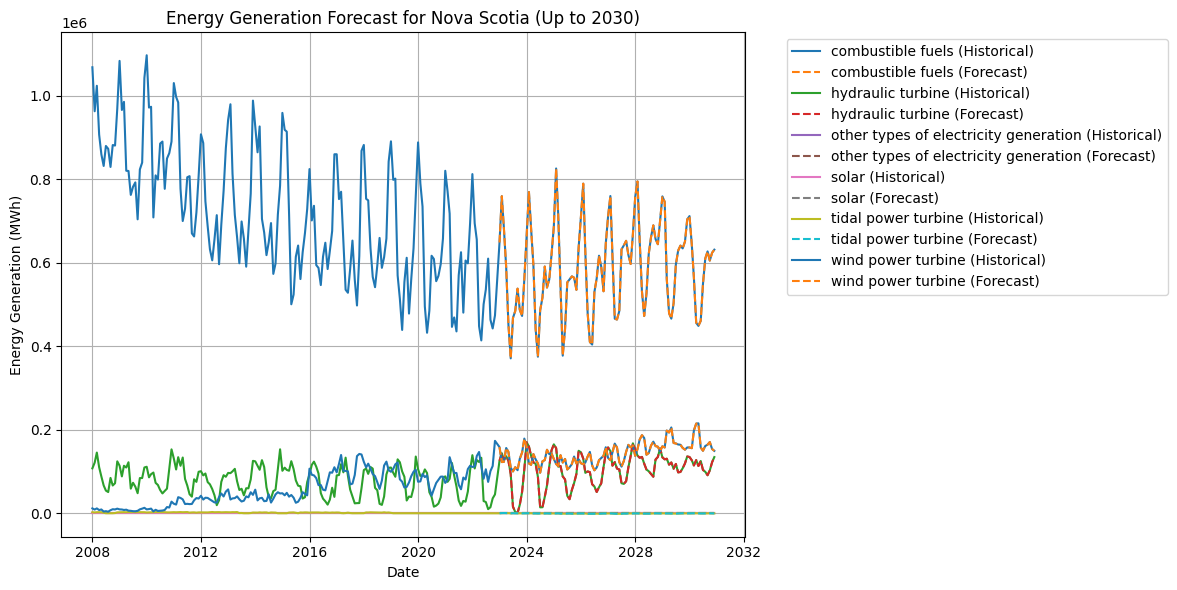

Processing Nunavut...
Epoch 1/100
5/5 - 3s - loss: 0.5482 - mae: 0.6188 - 3s/epoch - 593ms/step
Epoch 2/100
5/5 - 0s - loss: 0.1128 - mae: 0.2649 - 229ms/epoch - 46ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0353 - mae: 0.1529 - 240ms/epoch - 48ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0215 - mae: 0.1113 - 254ms/epoch - 51ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0167 - mae: 0.1064 - 270ms/epoch - 54ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0116 - mae: 0.0739 - 271ms/epoch - 54ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0073 - mae: 0.0613 - 272ms/epoch - 54ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0066 - mae: 0.0550 - 274ms/epoch - 55ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0052 - mae: 0.0466 - 273ms/epoch - 55ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0049 - mae: 0.0500 - 263ms/epoch - 53ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0039 - mae: 0.0414 - 262ms/epoch - 52ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0036 - mae: 0.0401 - 258ms/epoch - 52ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0033 - mae: 0.0361 - 268ms/epoch 

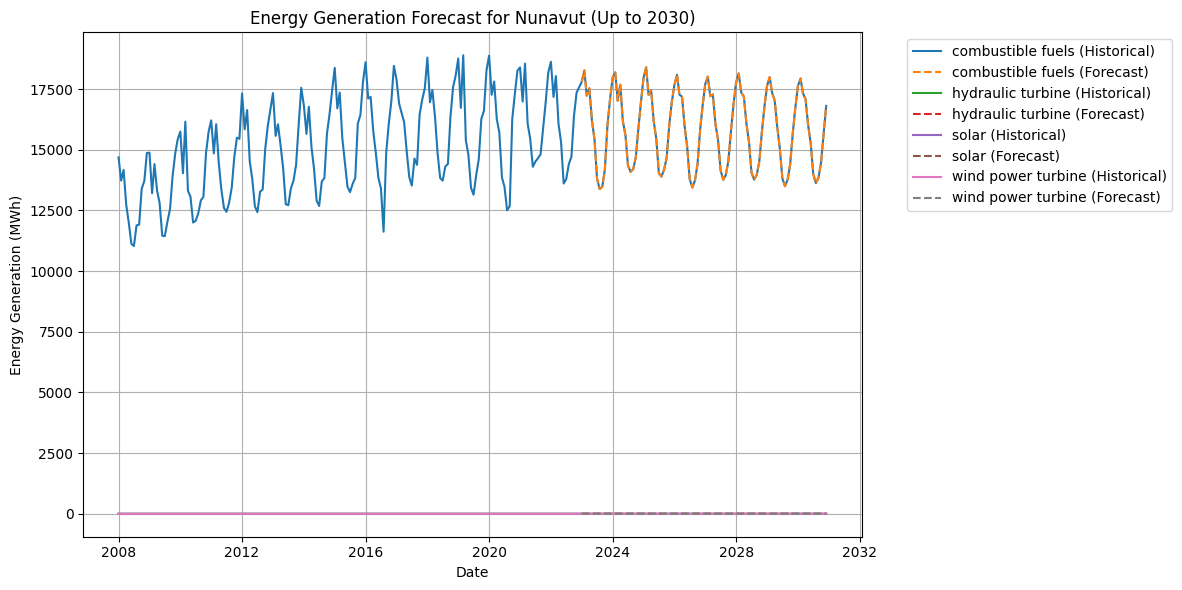

Processing Ontario...
Epoch 1/100
5/5 - 3s - loss: 0.5198 - mae: 0.5758 - 3s/epoch - 684ms/step
Epoch 2/100
5/5 - 0s - loss: 0.0978 - mae: 0.2473 - 235ms/epoch - 47ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0478 - mae: 0.1762 - 252ms/epoch - 50ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0326 - mae: 0.1461 - 274ms/epoch - 55ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0272 - mae: 0.1280 - 282ms/epoch - 56ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0207 - mae: 0.1088 - 323ms/epoch - 65ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0185 - mae: 0.1033 - 294ms/epoch - 59ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0158 - mae: 0.0935 - 339ms/epoch - 68ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0152 - mae: 0.0897 - 347ms/epoch - 69ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0138 - mae: 0.0848 - 299ms/epoch - 60ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0135 - mae: 0.0821 - 333ms/epoch - 67ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0125 - mae: 0.0795 - 363ms/epoch - 73ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0122 - mae: 0.0788 - 360ms/epoch 

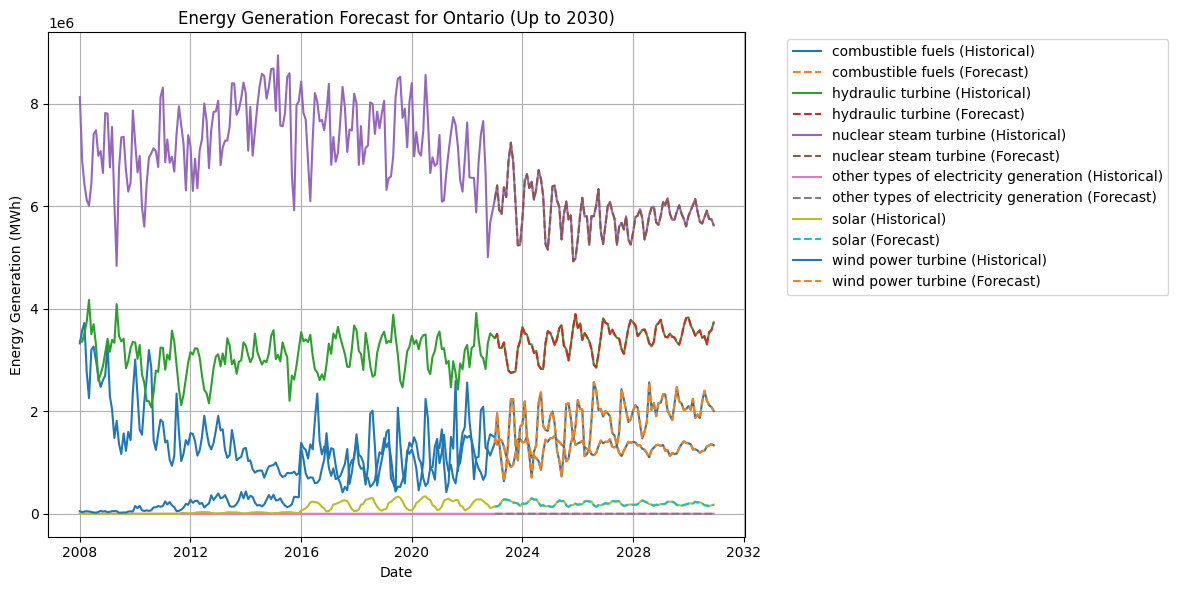

Processing Prince Edward Island...
Epoch 1/100
5/5 - 2s - loss: 0.5685 - mae: 0.5897 - 2s/epoch - 471ms/step
Epoch 2/100
5/5 - 0s - loss: 0.1322 - mae: 0.2778 - 241ms/epoch - 48ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0644 - mae: 0.1907 - 267ms/epoch - 53ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0358 - mae: 0.1459 - 278ms/epoch - 56ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0235 - mae: 0.1155 - 323ms/epoch - 65ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0196 - mae: 0.1021 - 313ms/epoch - 63ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0151 - mae: 0.0890 - 307ms/epoch - 61ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0134 - mae: 0.0831 - 304ms/epoch - 61ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0114 - mae: 0.0754 - 306ms/epoch - 61ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0100 - mae: 0.0705 - 308ms/epoch - 62ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0093 - mae: 0.0673 - 305ms/epoch - 61ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0087 - mae: 0.0641 - 307ms/epoch - 61ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0080 - mae: 0.0623 -

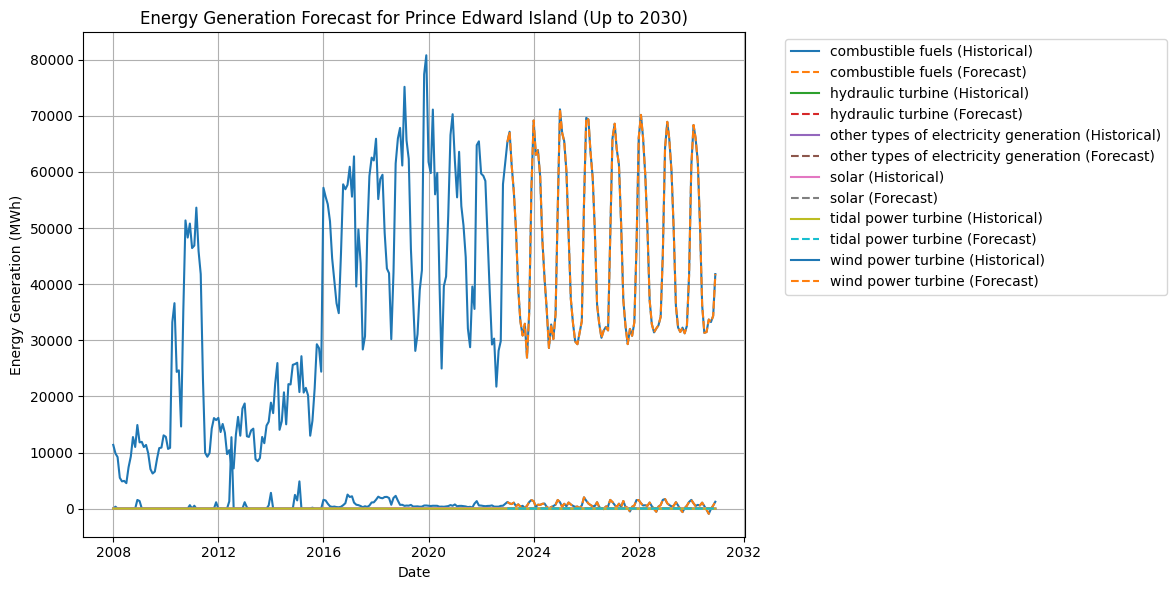

Processing Quebec...
Epoch 1/100
5/5 - 2s - loss: 0.4048 - mae: 0.4898 - 2s/epoch - 469ms/step
Epoch 2/100
5/5 - 0s - loss: 0.0945 - mae: 0.2433 - 248ms/epoch - 50ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0588 - mae: 0.1815 - 265ms/epoch - 53ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0364 - mae: 0.1455 - 271ms/epoch - 54ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0259 - mae: 0.1193 - 280ms/epoch - 56ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0200 - mae: 0.1087 - 291ms/epoch - 58ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0166 - mae: 0.0985 - 292ms/epoch - 58ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0133 - mae: 0.0852 - 296ms/epoch - 59ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0121 - mae: 0.0818 - 294ms/epoch - 59ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0103 - mae: 0.0728 - 292ms/epoch - 58ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0097 - mae: 0.0718 - 293ms/epoch - 59ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0086 - mae: 0.0659 - 298ms/epoch - 60ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0081 - mae: 0.0626 - 296ms/epoch -

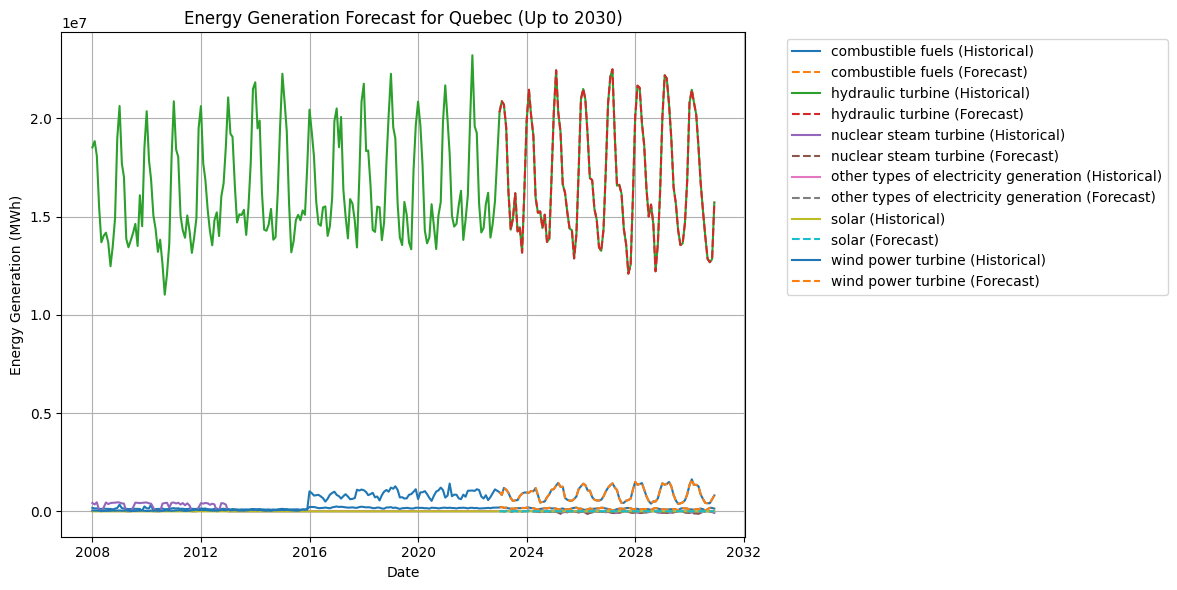

Processing Saskatchewan...
Epoch 1/100
5/5 - 2s - loss: 0.4386 - mae: 0.5295 - 2s/epoch - 478ms/step
Epoch 2/100
5/5 - 0s - loss: 0.0897 - mae: 0.2280 - 218ms/epoch - 44ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0529 - mae: 0.1941 - 234ms/epoch - 47ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0348 - mae: 0.1445 - 249ms/epoch - 50ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0294 - mae: 0.1221 - 254ms/epoch - 51ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0237 - mae: 0.1214 - 266ms/epoch - 53ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0207 - mae: 0.1087 - 276ms/epoch - 55ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0185 - mae: 0.1011 - 268ms/epoch - 54ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0172 - mae: 0.1012 - 265ms/epoch - 53ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0160 - mae: 0.0943 - 263ms/epoch - 53ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0143 - mae: 0.0910 - 268ms/epoch - 54ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0135 - mae: 0.0876 - 264ms/epoch - 53ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0128 - mae: 0.0865 - 267ms/e

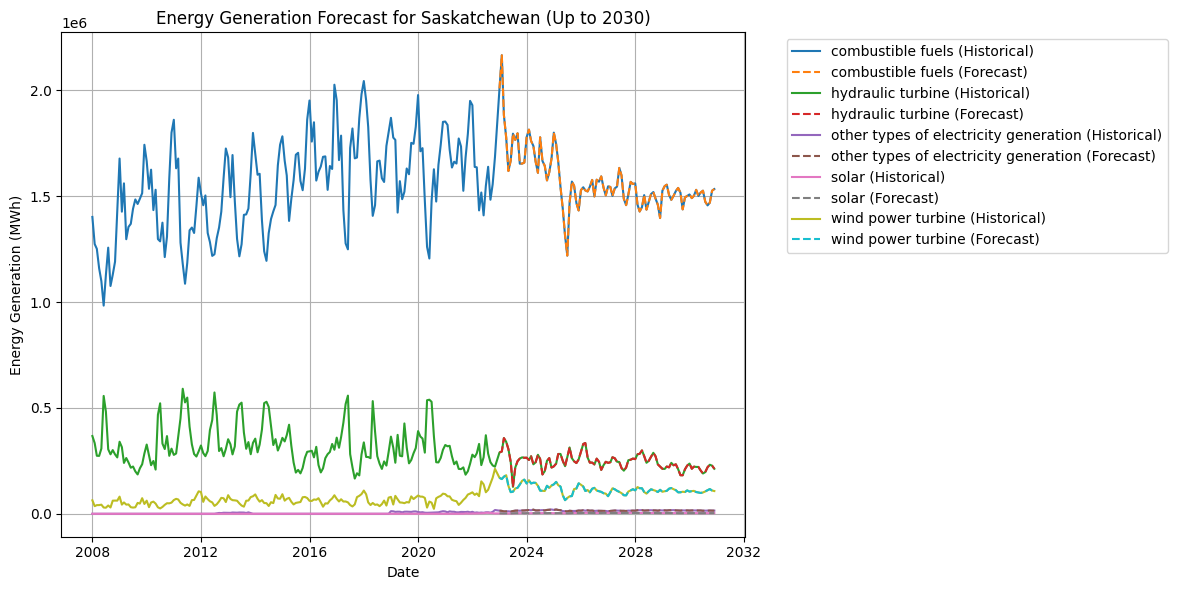

Processing Yukon...
Epoch 1/100
5/5 - 2s - loss: 0.5087 - mae: 0.5413 - 2s/epoch - 483ms/step
Epoch 2/100
5/5 - 0s - loss: 0.1181 - mae: 0.2768 - 225ms/epoch - 45ms/step
Epoch 3/100
5/5 - 0s - loss: 0.0535 - mae: 0.1880 - 239ms/epoch - 48ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0320 - mae: 0.1384 - 256ms/epoch - 51ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0281 - mae: 0.1243 - 266ms/epoch - 53ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0203 - mae: 0.1125 - 275ms/epoch - 55ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0172 - mae: 0.0976 - 274ms/epoch - 55ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0165 - mae: 0.0901 - 272ms/epoch - 54ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0135 - mae: 0.0839 - 275ms/epoch - 55ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0128 - mae: 0.0821 - 271ms/epoch - 54ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0113 - mae: 0.0731 - 274ms/epoch - 55ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0106 - mae: 0.0744 - 271ms/epoch - 54ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0103 - mae: 0.0713 - 270ms/epoch - 

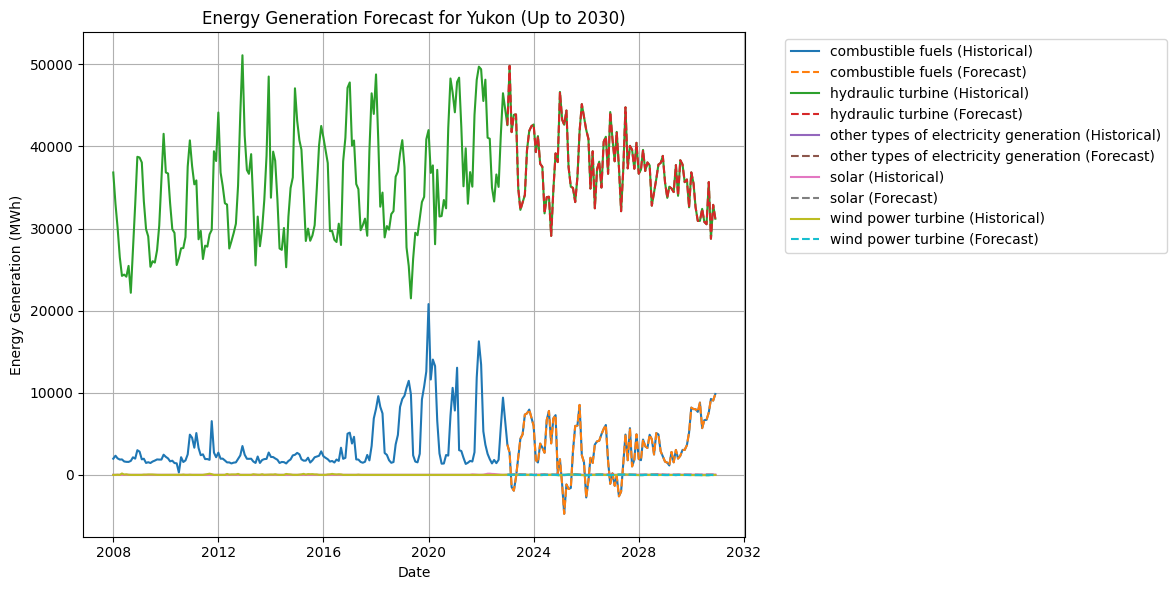

Forecasts for 2029–2030 saved to 'forecast_2029_2030.csv'.


In [11]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tcn import TCN

#random seed for reproducibility
np.random.seed(42)


# ------------------ Utility Functions ------------------ #
def load_and_preprocess_data(filepath):
    """Load and preprocess the dataset."""
    data = pd.read_csv(filepath)
    data['date'] = pd.to_datetime(data['date'])
    df_grouped = data.groupby(['date', 'generation_type'], as_index=False)['megawatt_hours'].sum()
    return df_grouped

def standardize_generation_types(df, unique_types):
    """Ensure all generation types are represented for every date."""
    all_dates = df['date'].unique()
    standardized_rows = [
        {'date': date, 'generation_type': g_type, 'megawatt_hours': 0}
        for date in all_dates
        for g_type in unique_types
        if g_type not in df[df['date'] == date]['generation_type'].values
    ]
    return pd.concat([df, pd.DataFrame(standardized_rows)], ignore_index=True)

def scale_data(df):
    """Scale the data using MinMaxScaler."""
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

def create_sequences(data, n_steps):
    """Create input-output sequences for time-series data."""
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

def forecast_future(model, data_scaled, scaler, n_steps, forecast_horizon, columns):
    """Forecast future energy generation."""
    forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, data_scaled.shape[1])
    forecast = []
    for _ in range(len(forecast_horizon)):
        prediction = model.predict(forecast_input, verbose=0)
        forecast.append(prediction[0])
        forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)
    forecast_rescaled = scaler.inverse_transform(forecast)
    return pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=columns)

def plot_forecasts(full_df, forecast_df, title):
    """Plot the historical data and full forecasted values."""
    plt.figure(figsize=(12, 6))
    for column in full_df.columns:
        plt.plot(full_df.index, full_df[column], label=f"{column} (Historical)")
        plt.plot(forecast_df.index, forecast_df[column], label=f"{column} (Forecast)", linestyle='--')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Energy Generation (MWh)")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.grid()
    plt.show()

def build_tcn_model(input_shape, output_shape):
    """Build the TCN model with predefined hyperparameters."""
    model = Sequential([
        Input(shape=input_shape),
        TCN(
            nb_filters=80,  # Number of filters
            kernel_size=3,  # Kernel size
            nb_stacks=1,  # Number of stacks
            dilations=[2**i for i in range(6)],  # Dilation depth of 6
            padding='causal',
            use_skip_connections=False,
            dropout_rate=0.0,  # No dropout
            activation='tanh',
        ),
        Dense(units=output_shape)  # Match the number of target features
    ])
    model.compile(
        optimizer='adam',  # Optimizer
        loss='mse',
        metrics=['mae']
    )
    return model

# ------------------ Main Script ------------------ #
if __name__ == "__main__":
    # Folder containing the CSV files
    data_folder = r'data/processed/'  # Adjust path if necessary

    # List of all province files
    province_files = [
        "alberta_energy.csv",
        "british_columbia_energy.csv",
        "manitoba_energy.csv",
        "new_brunswick_energy.csv",
        "newfoundland_and_labrador_energy.csv",
        "northwest_territories_energy.csv",
        "nova_scotia_energy.csv",
        "nunavut_energy.csv",
        "ontario_energy.csv",
        "prince_edward_island_energy.csv",
        "quebec_energy.csv",
        "saskatchewan_energy.csv",
        "yukon_energy.csv"
    ]

    # Initialize an empty DataFrame to store only 2029–2030 forecasts
    combined_forecasts = pd.DataFrame(columns=['province', 'generation_type', 'month', 'megawatt_hours'])

    # Forecast horizon for 2029 to 2030
    forecast_horizon_start = '2023-01-01'
    forecast_horizon_end = '2030-12-01'

    # Process each province file
    for file_name in province_files:
        province_name = file_name.replace('_energy.csv', '').replace('_', ' ').title()
        print(f"Processing {province_name}...")
        file_path = os.path.join(data_folder, file_name)

        # Load and preprocess data
        df_grouped = load_and_preprocess_data(file_path)
        unique_generation_types = df_grouped['generation_type'].unique()
        df_standardized = standardize_generation_types(df_grouped, unique_generation_types)
        df_pivot = df_standardized.pivot(index='date', columns='generation_type', values='megawatt_hours').fillna(0)
        df_pivot[df_pivot < 0] = 0

        # Scale data
        data_scaled, scaler = scale_data(df_pivot)

        # Create sequences
        n_steps = 36
        X, y = create_sequences(data_scaled, n_steps)
        input_shape = (n_steps, X.shape[2])
        output_shape = X.shape[2]

        # Build and train model
        model = build_tcn_model(input_shape, output_shape)
        model.fit(X, y, epochs=100, batch_size=32, verbose=2)

        # Forecast future values
        forecast_horizon = pd.date_range(forecast_horizon_start, forecast_horizon_end, freq='MS')
        forecast_df = forecast_future(model, data_scaled, scaler, n_steps, forecast_horizon, df_pivot.columns)

        # Combine historical and forecasted data for plotting
        full_df = pd.concat([df_pivot, forecast_df], axis=0)

        # Save only 2029–2030 data for the combined CSV
        forecast_df = forecast_df.reset_index().melt(id_vars='index', var_name='generation_type', value_name='megawatt_hours')
        forecast_df.rename(columns={'index': 'month'}, inplace=True)
        forecast_df['province'] = province_name
        forecast_2029_2030 = forecast_df[forecast_df['month'].dt.year >= 2029]
        combined_forecasts = pd.concat([combined_forecasts, forecast_2029_2030], ignore_index=True)

        # Plot all historical and forecasted data
        plot_forecasts(full_df, forecast_df.pivot(index='month', columns='generation_type', values='megawatt_hours'),
                       f"Energy Generation Forecast for {province_name} (Up to 2030)")

    # Save the combined forecasts to a CSV file
    combined_forecasts.to_csv('forecast_2029_2030.csv', index=False)
    print("Forecasts for 2029–2030 saved to 'forecast_2029_2030.csv'.")
